# EE 341–Audio Fingerprint / Shazam - Lab 6

## Background

In this project, you will build a simple Shazam-like system to identify a short clip of a song from a database of songs. Shazam (supposedly) has a database of songs matching their unique features(fingerprints). When the system is fed with a song with its name to be detected, the system does the following
- Obtains the song’s fingerprint 
- Matches the fingerprint with the ones that are stored in the database
- Returns a song whose fingerprint has the closest match to the ones from the song to be detected.

The feature of a song is obtained by marking its local peaks location in the magnitude of its spectrogram. A spectrogram is a plot of Time-Dependent Fourier Transform of a song.

Spectrogram and Time-Dependent Fourier Transform

A spectrogram is an extension of a spectrum. Recall that a spectrum could be generated by Fourier Transform for a whole signal. It is a 2D graph (Magnitude / Phase vs Frequency) which shows the frequency components of the signal. Whereas the spectrogram is a 3D plot that adds a time dimension on the top of the two dimensions from Fourier Transform (Magnitude / Phase and Frequency). A spectrogram of a signal could be obtained by Time-Dependent Fourier Transform (which is also called Short-time Fourier Transform). It could be interpreted as a Fourier Transform that depends on time. Here the Fourier Transform no longer applies to the whole signal, instead, it applies to a fixed short-time segment of the signal. Thus, as we choose different segments of the signal, we will obtain different Fourier Transforms of the segments. In this way, we could plot the spectrogram of the whole signal.

So far we have learned that the database of the Shazam-like system stores a table of song names with the features corresponding to the song. For each song, we mark the frequencies and time of the peaks as features. To simplify calculation, we will only use paris of peaks that are close in both time and frequency as features. Thus, the database would keep a table with one row for each peak pair with the song id they belong to like follows

| t1| t2 | f1 | f2|songid |
|---|--- |----|---|-------|
|324|328 |  26|34 |"song1"|
|...|... |...|...|...|

For each song in the Shazam database, these feature pairs arestored in a hash table for easy access. The hash value is calculated from the vector $(f_1, f_2, t_2- t_1)$ so that the same frequencies and separation in time are considered a match. In this way, it will be robust to possible time distortion. 

We could then store the timing $t_1$ and $songid$ in the hash table. When a clip of song is to be identified, the list of pairs of peaks is produced, just as it would havebeen for a song in the database. Then the hash table is searched for each pair in the clip. This will produce a list of matches, each with different stored values of $t_1$ and songid. Some of these matches will be accidental, either because the same peak pair occurred at another time or in another song, or because the hash table had a collision. However, we expect the correct song match to have a consistent timing offset from the clip. That is, the difference between $t_1$ for the song and $t_1$ for the clip should be the same for all correct matches. The song with the most matches for a single timing offset is declared the winner.


We will use `SciPy` package for the whole lab.

In [1]:
from scipy.io import wavfile
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

## Part 1 
#### A function getFingerprint() summarizes the work in part1

Part 1 of the project will be buiding the database for the songs. You would use any MP3 files you want. (We suggest the MP3 with vocal since Shazam performs worse for the ones without vocal) The main steps are the following:
- Read in the song using `wavfile.read`.
- Average the two channels, subtract the mean, and downsample.
- Compute the spectrogram of the song using `spectrogram`.
- Find the local peaks of the spectrogram by using `circshift` in a loop.
- Threshold the result of step 5 to end up with a specified rate of peaks retained per second of sound.
- Find pairs of proximal peaks and add load them into a hash table.

### 1.1 Reading an MP3 File

In [ ]:
rate, data = wavfile.read('')
print(data)

### 1.2 Preprocessing

Here you should average the two channels of the audio file, subtract the mean of the signal, and downsample it to 8000 Hz using `signal.resample`.

In [ ]:
fs = 8000
ch1 = data[:,0]
ch2 = data[:,1]
new_data = (ch1+ch2)/2
print("average: \n", new_data, "\n")
new_data = new_data - np.mean(new_data)
print("average - mean: \n", new_data, "\n")
new_data = signal.resample(new_data, fs)
print("downsampled: \n", new_data, "\n")

### 1.3 Creating Spectrogram

Here you should construcct the spectrogram of the signal using `signal.spectrogram`

In [ ]:
f, t, spectrogram = signal.spectrogram(new_data, fs)
print(len(f))
print(len(t))
print("lengths of the 2 dimensions of Spectrogram: ", spectrogram.shape)
print("size of Spectrogram: ", spectrogram.size)
plt.pcolormesh(t, f, spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


### 1.4 Finding Local Peaks

Next, we find the local peaks of the spectrogram and produce a binary matrix (the same size as the spec- trogram) with a 1 at each location of a peak.


In [ ]:
#create an empty fingerprint

fingerprint1 = np.zeros(spectrogram.size)
print(len(fingerprint1))
fingerprint1 = fingerprint1.reshape(len(spectrogram), len(spectrogram[0]))
print(len(fingerprint1))
print(len(fingerprint1[0]))

In [ ]:
#method 1

f_len = len(spectrogram)
print(f_len)
t_len = len(spectrogram[0])
print(t_len)
maxval = np.zeros(f_len)

for i in range(0, f_len):
    for j in range(1, t_len-2):
        #run through the time domain to find the max
        #if the current index value is greater than the two values besides it, return a 1
        if spectrogram[i][j] > spectrogram[i][j-1] and spectrogram[i][j] > spectrogram[i][j+1]: 
            fingerprint1[i][j] = 1
        else: 
            fingerprint1[i][j] = 0
    maxval[i] = max(spectrogram[i])
print(max(maxval))
t_axis = np.linspace(0, t_len, t_len)
f_axis = np.linspace(0, f_len, f_len)
plt.pcolormesh(t_axis, f_axis, fingerprint1)

### 1.5 Thresholding

We want to only use the larger peaks.Set up a poper threshold and get rid of the small peaks.

In [ ]:
#determining the threshold value
peaks = np.ndarray.flatten(fingerprint1 * spectrogram)
peaks = np.sort(peaks)[::-1]
print(peaks)
threshold = peaks[30]
print(threshold)

In [ ]:
counter = 0
new_fingerprint = fingerprint1 * spectrogram
for i in range (0, len(new_fingerprint)):
    for j in range (0, len(new_fingerprint[0])):
        if (new_fingerprint[i][j] > threshold):
            new_fingerprint[i][j] = 1
            counter = counter + 1
        else:
            new_fingerprint[i][j] = 0
coordinates = np.argwhere(new_fingerprint>0)
plt.pcolormesh(t_axis, f_axis, new_fingerprint)

### getFingerprint() function: Get the fingerprint of a song given its rate and signal
a summary of previous exercises

In [2]:
def getFingerprint(song_name, rate, data):
    print("\nCreate a new fingerprint of the song:")
    print(song_name, ":")
    #pre-processing
    fs = 8000
    if data.ndim == 2:
        ch1 = data[:,0]
        ch2 = data[:,1]
        new_data = (ch1+ch2)/2
    else:
        new_data = data
    new_data = new_data - np.mean(new_data)
    new_data = signal.resample(new_data, fs)
    
    #create spectrogram
    print("show spectrogram of the song: ")
    f, t, spectrogram = signal.spectrogram(new_data, fs)
    plt.figure(0)
    plt.pcolormesh(t, f, spectrogram)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

    #create an empty fingerprint
    fingerprint1 = np.zeros(spectrogram.size)
    fingerprint1 = fingerprint1.reshape(len(spectrogram), len(spectrogram[0]))
    
    #finding peaks in fingerprint 
    f_len = len(spectrogram)
    t_len = len(spectrogram[0])
    maxval = np.zeros(f_len)

    for i in range(0, f_len):
        for j in range(1, t_len-2):
            #run through the time domain to find the max
            #if the current index value is greater than the two values besides it, return a 1
            if spectrogram[i][j] > spectrogram[i][j-1] and spectrogram[i][j] > spectrogram[i][j+1]: 
                fingerprint1[i][j] = 1
            else: 
                fingerprint1[i][j] = 0
        maxval[i] = max(spectrogram[i])
    t_axis = np.linspace(0, t_len, t_len)
    f_axis = np.linspace(0, f_len, f_len)
    plt.pcolormesh(t_axis, f_axis, fingerprint1)
    
    #filtering the peaks
    #determining the threshold value
    peaks = np.ndarray.flatten(fingerprint1 * spectrogram)
    peaks = np.sort(peaks)[::-1]
    threshold = peaks[30]
    
    #creating a new fingerprint
    counter = 0
    new_fingerprint = fingerprint1 * spectrogram
    for i in range (0, len(new_fingerprint)):
        for j in range (0, len(new_fingerprint[0])):
            if (new_fingerprint[i][j] > threshold):
                new_fingerprint[i][j] = 1
                counter = counter + 1
            else:
                new_fingerprint[i][j] = 0
    coordinates = np.argwhere(new_fingerprint>0)
    plt.figure(1)
    plt.pcolormesh(t_axis, f_axis, new_fingerprint)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    print("finished creating a fingerprint\n\n")
    
    return new_fingerprint

### 1.6 Finding peak pairs

Rewrite the Matlab file `convert_to_pairs` to Python. The code finds pairs by considering each peak and looking for other peaks within a designated window located relative to it. During the search, we limit the number of pairs that we accept by the parameter fanout. The code is written to scan through the window column by column, accepting the first pairings that it finds. 

A peak-pair must satisfy certain constraints: 
#del_f: the second peak must fall within a given distance from the frequency of the first peak
#del_t: the second peak must occur within a certain time interval after the first peak. 
#fanout: We will also limit the number of pairs allowed to form from a given peak, say to 3 (this is called the fan-out)

In [3]:
def convert_to_pairs (fingerprint):
# This code takes a binary matrix as input and returns a list of proximate
# peaks.  There are three parameters in the code to change the range of the
# search and the number of pairs allowed per peak.
#
# There is also an optional plot which shows the peaks and lines connecting
# the pairs.  Zoom in to the plot to see the peaks better.

    del_t = 10 # bound on time difference (in pixels)
    del_f = 10 # bound on frequency difference (in pixels)
    fanout = 3 # Maximum number of pairs per peak.

    #make table format
    coordinates = np.nonzero(fingerprint)
    #print(coordinates)
    f = coordinates[0]
    t = coordinates[1]
    #print(f)
    #print(t)
    peakCount = len(f)

    f_size, t_size = fingerprint.shape
    index = 1;

    table = np.zeros((fanout*peakCount, 4))

    for i in range (1,peakCount):
        links = 0
        for f2 in range(min(f_size,f[i]+1), min(f_size,f[i]+del_f)):
            if fingerprint[f2,t[i]] == 1:
                table[index] = [t[i], t[i], f[i], f2]
                links = links + 1
                index = index + 1
            if (links >= fanout):
                break
        for t2 in range(min(t_size,t[i]+1), min(t_size,t[i]+del_t)):
            if (links >= fanout):
                break
            for f2 in range(max(1,f[i]-del_f), min(f_size, f[i]+del_f)):
                if (links >= fanout):
                    break
                if fingerprint[f2,t2] == 1:
                    table[index] = [t[i], t2, f[i], f2]
                    links = links + 1
                    index = index + 1

    table = table[1:(index - 1), :]
    print(table)
    return table


### 1.7 Creating Database

Two other m-files are provided. The first one, add to table.m, edits a global variable called hashtable. We’ll discuss that more in part 2 of the procedure. The other one, make database.m, is a script that searches for all MP3 files in a designated folder and processes them if they are not already in the database.
Rewrite the two functions into Python and make the appropriate changes to make database so that it properly processes the music files. 

In [4]:
#This is just intended to be a chaotic function with roughly a uniform distribution over the range.
def simple_hash (f1, f2, deltaT, size):
#     print("\nf1 = ", f1)
#     print("f2 = ", f2)
#     print("deltaT = ", deltaT)
#     print("size = ", size)
    hash_index = round(size*1000000*(np.log(abs(f1)+2) + 2*np.log(abs(f2)+2) + 3*np.log(abs(deltaT)+2))) % size + 1
    #print("hash_index = ", hash_index)
    return int(hash_index)

In [5]:
def add_to_table(table, songidnum):

# Pass to this function a list of proximate pairs and the song ID number of
# the song that the pairs were taken from.
# 
# This function changes a global variable:  hashtable.  The tuples are
# appended to the hashtable.  The return value is not crucial, only for
# information.

    global hashtable

    hashTableSize = np.shape(hashtable)[0]
    # print("\nhashTableSize = ", hashTableSize)

    # Count the max number of collisions for a given hash (FYI)
    maxCollisions = 0;

    number_of_pairs, elements_in_pairs = table.shape

    for m in range(1,number_of_pairs):
        hash_index = simple_hash(table[m][2],table[m][3], table[m][1]-table[m][0], hashTableSize)
        #  first instance of this hash
        if not hashtable[hash_index][0]: #check if the current element is empty
            hashtable[hash_index][0].append(songidnum) # id of the song
            hashtable[hash_index][1].append(table[m][0])
        # duplicate instance of this hash
        else:
            hashtable[hash_index][0].append(songidnum) #append songidnum
            hashtable[hash_index][1].append(table[m][0]) #append table[m, 0] (to the hash_index (key)

            collisions = len(hashtable[hash_index][0])
            if collisions > maxCollisions:
                maxCollisions = collisions

In [6]:
import os

def getWavList(directory):
# This function returns a list of filenames that contain '.wav' in the
# specified directory.
    entries = os.listdir(directory)
    names = []
    for files in entries:
        #print(files)
        names.append((files))
    #print(names)
    
    songList = []
    for i in range (0, len(names)):
        if (names[i].find('wav') != -1):
            songList.append(names[i])
    if (len(songList) == 0):
        print("No WAVs Found")
    return songList
    

In [7]:
#load and print a file
def load(file):
    result = []
    with open(file, 'r') as reader:
        # Read and print the entire file line by line
        line = reader.readline()
        result.append(line)
        while line != '':  # The EOF char is an empty string
            print(line, end='')
            line = reader.readline()
            result.append(line)
    return result
            

In [8]:
# Read all WAV files in 'path' and add them to the database training if they
# are not already in 'songid'
path = 'C:/Users/USER/Desktop/UW/courses/20 WI/EE 341/Lab/Lab6_Shazam'
songs = (getWavList(path))
# print(songs) 

In [9]:
# Check if we have a database in the workspace

hashTableSize = 100000 # This can be adjusted.  Setting it too small will cause more accidental collisions.

global hashtable

if not 'songid' in locals(): #change later if needed
    #print("test")
    # Load database if one exists
    if os.path.exists('database.txt'):
        print("exist")
        #read songid from file
        with open('SONGID.txt', 'r') as songid_file:
            songid = []
            for line in songid_file.readlines():
                songid.append(line)

        ##read hashtable from file
        with open('HASHTABLE.txt', 'r') as reader:
            hashtable = [[[], []] for i in range (0, hashTableSize)] #initialize a new hashtable
            line_num = 0
            for line in reader.readlines():
                i = 0
                for word in line.split():
                    if word == "/":
                        i = 1
                    elif word != " ":
                        hashtable[line_num][i].append(float(word))
                        print(float(word))
                        print("\n")
                line_num = line_num + 1
        reader.close()
    else:
        # Create new database
        print("doesn't exist")
        songid = []
        hashtable = [[[], []] for i in range (0, hashTableSize)]

doesn't exist


['blm.wav', 'do.wav', 'example.wav', 'mmm_fixed.wav', 'music.wav', 'tiger_fixed.wav', 'toad_fixed.wav']

Create a new fingerprint of the song:
blm.wav :
show spectrogram of the song: 


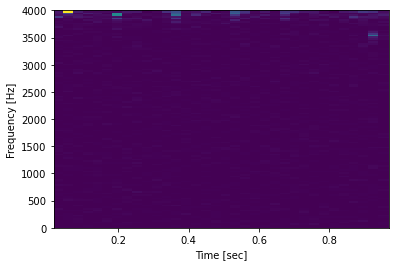

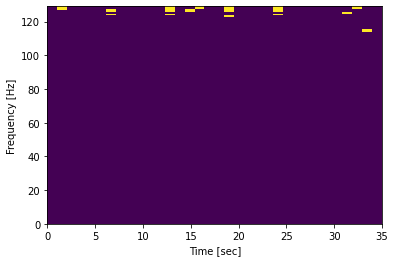

finished creating a fingerprint


[[ 18.  18. 122. 125.]
 [ 18.  18. 122. 126.]
 [ 18.  18. 122. 127.]
 [  6.   6. 123. 125.]
 [  6.   6. 123. 126.]
 [  6.  12. 123. 123.]
 [ 12.  12. 123. 125.]
 [ 12.  12. 123. 126.]
 [ 12.  12. 123. 127.]
 [ 23.  23. 123. 125.]
 [ 23.  23. 123. 126.]
 [ 23.  23. 123. 127.]
 [ 30.  31. 124. 127.]
 [ 30.  31. 124. 128.]
 [ 30.  32. 124. 114.]
 [  6.   6. 125. 126.]
 [  6.  12. 125. 123.]
 [  6.  12. 125. 125.]
 [ 12.  12. 125. 126.]
 [ 12.  12. 125. 127.]
 [ 12.  12. 125. 128.]
 [ 14.  14. 125. 126.]
 [ 14.  15. 125. 127.]
 [ 14.  18. 125. 122.]
 [ 18.  18. 125. 126.]
 [ 18.  18. 125. 127.]
 [ 18.  19. 125. 128.]
 [ 23.  23. 125. 126.]
 [ 23.  23. 125. 127.]
 [ 23.  27. 125. 128.]
 [  1.   1. 126. 127.]
 [  1.   1. 126. 128.]
 [  1.   6. 126. 123.]
 [  6.  12. 126. 123.]
 [  6.  12. 126. 125.]
 [  6.  12. 126. 126.]
 [ 12.  12. 126. 127.]
 [ 12.  12. 126. 128.]
 [ 12.  14. 126. 125.]
 [ 14.  15. 126. 127.]
 [ 14.  18. 126. 122.]
 [ 14.  18. 126. 125.]


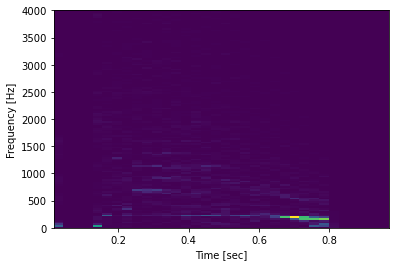

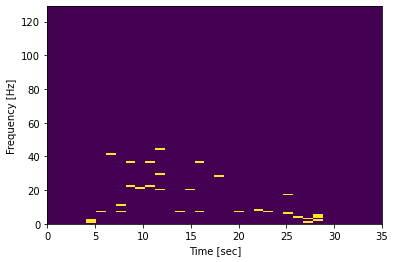

finished creating a fingerprint


[[26. 26.  1.  3.]
 [26. 27.  1.  2.]
 [26. 27.  1.  4.]
 [ 4.  5.  2.  7.]
 [ 4.  7.  2.  7.]
 [ 4.  7.  2. 11.]
 [27. 27.  2.  4.]
 [27. 27.  2.  5.]
 [26. 27.  3.  2.]
 [26. 27.  3.  4.]
 [26. 27.  3.  5.]
 [25. 26.  4.  1.]
 [25. 26.  4.  3.]
 [25. 27.  4.  2.]
 [27. 27.  4.  5.]
 [24. 25.  6.  4.]
 [24. 26.  6.  1.]
 [24. 26.  6.  3.]
 [ 5.  7.  7.  7.]
 [ 5.  7.  7. 11.]
 [ 5. 13.  7.  7.]
 [ 7.  7.  7. 11.]
 [ 7. 13.  7.  7.]
 [ 7. 15.  7.  7.]
 [13. 15.  7.  7.]
 [13. 19.  7.  7.]
 [13. 21.  7.  8.]
 [15. 19.  7.  7.]
 [15. 21.  7.  8.]
 [15. 22.  7.  7.]
 [19. 21.  7.  8.]
 [19. 22.  7.  7.]
 [19. 24.  7.  6.]
 [22. 24.  7.  6.]
 [22. 25.  7.  4.]
 [22. 26.  7.  1.]
 [21. 22.  8.  7.]
 [21. 24.  8.  6.]
 [21. 24.  8. 17.]
 [ 7. 11. 11. 20.]
 [ 7. 13. 11.  7.]
 [ 7. 14. 11. 20.]
 [11. 11. 20. 29.]
 [11. 14. 20. 20.]
 [11. 17. 20. 28.]
 [14. 17. 20. 28.]
 [ 9. 10. 21. 22.]
 [ 9. 11. 21. 20.]
 [ 9. 11. 21. 29.]
 [ 8.  9. 22. 21.]
 [ 8. 10. 22. 22

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: WavFileWarning: Chunk (non-data) not understood, skipping it.


show spectrogram of the song: 


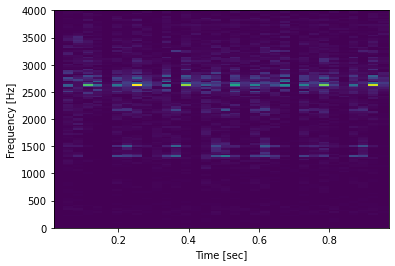

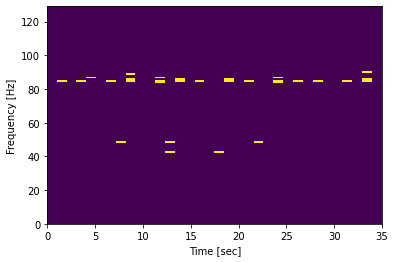

finished creating a fingerprint


[[17. 21. 42. 48.]
 [ 7. 12. 48. 42.]
 [ 7. 12. 48. 48.]
 [12. 17. 48. 42.]
 [12. 21. 48. 48.]
 [11. 11. 83. 84.]
 [11. 11. 83. 86.]
 [11. 13. 83. 84.]
 [23. 23. 83. 84.]
 [23. 23. 83. 86.]
 [23. 25. 83. 84.]
 [ 1.  3. 84. 84.]
 [ 1.  4. 84. 86.]
 [ 1.  6. 84. 84.]
 [ 3.  4. 84. 86.]
 [ 3.  6. 84. 84.]
 [ 3.  8. 84. 84.]
 [ 6.  8. 84. 84.]
 [ 6.  8. 84. 85.]
 [ 6.  8. 84. 88.]
 [ 8.  8. 84. 85.]
 [ 8.  8. 84. 88.]
 [ 8. 11. 84. 83.]
 [11. 11. 84. 86.]
 [11. 13. 84. 84.]
 [11. 13. 84. 85.]
 [13. 13. 84. 85.]
 [13. 15. 84. 84.]
 [13. 18. 84. 84.]
 [15. 18. 84. 84.]
 [15. 18. 84. 85.]
 [15. 20. 84. 84.]
 [18. 18. 84. 85.]
 [18. 20. 84. 84.]
 [18. 23. 84. 83.]
 [20. 23. 84. 83.]
 [20. 23. 84. 84.]
 [20. 23. 84. 86.]
 [23. 23. 84. 86.]
 [23. 25. 84. 84.]
 [23. 27. 84. 84.]
 [25. 27. 84. 84.]
 [25. 30. 84. 84.]
 [25. 32. 84. 84.]
 [27. 30. 84. 84.]
 [27. 32. 84. 84.]
 [27. 32. 84. 85.]
 [30. 32. 84. 84.]
 [30. 32. 84. 85.]
 [30. 32. 84. 89.]
 [32. 32. 84. 85

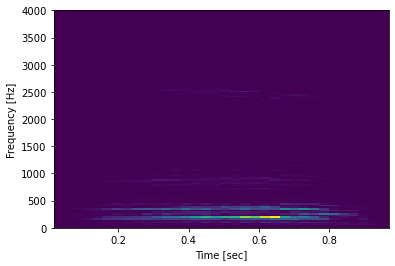

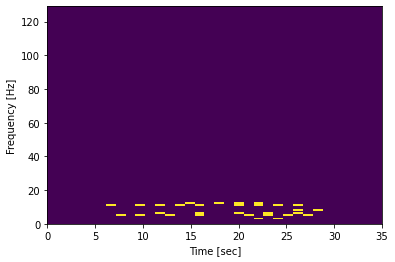

finished creating a fingerprint


[[23. 23.  3. 11.]
 [23. 24.  3.  5.]
 [23. 25.  3.  6.]
 [ 7.  9.  5.  5.]
 [ 7.  9.  5. 11.]
 [ 7. 11.  5.  6.]
 [ 9.  9.  5. 11.]
 [ 9. 11.  5.  6.]
 [ 9. 11.  5. 11.]
 [12. 13.  5. 11.]
 [12. 14.  5. 12.]
 [12. 15.  5.  5.]
 [15. 15.  5.  6.]
 [15. 15.  5. 11.]
 [15. 17.  5. 12.]
 [20. 21.  5.  3.]
 [20. 21.  5. 11.]
 [20. 21.  5. 12.]
 [22. 22.  5.  6.]
 [22. 23.  5.  3.]
 [22. 23.  5. 11.]
 [24. 25.  5.  6.]
 [24. 25.  5.  8.]
 [24. 25.  5. 11.]
 [26. 27.  5.  8.]
 [11. 11.  6. 11.]
 [11. 12.  6.  5.]
 [11. 13.  6. 11.]
 [15. 15.  6. 11.]
 [15. 17.  6. 12.]
 [15. 19.  6.  6.]
 [19. 19.  6. 11.]
 [19. 19.  6. 12.]
 [19. 20.  6.  5.]
 [22. 23.  6.  3.]
 [22. 23.  6. 11.]
 [22. 24.  6.  5.]
 [25. 25.  6.  8.]
 [25. 25.  6. 11.]
 [25. 26.  6.  5.]
 [25. 25.  8. 11.]
 [25. 26.  8.  5.]
 [25. 27.  8.  8.]
 [ 6.  7. 11.  5.]
 [ 6.  9. 11.  5.]
 [ 6.  9. 11. 11.]
 [ 9. 11. 11.  6.]
 [ 9. 11. 11. 11.]
 [ 9. 12. 11.  5.]
 [11. 12. 11.  5.]
 [11. 13. 11. 11

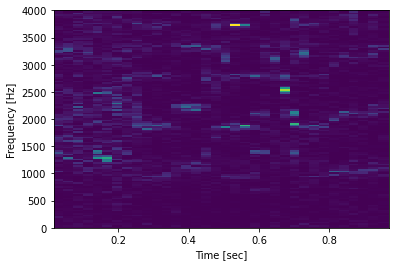

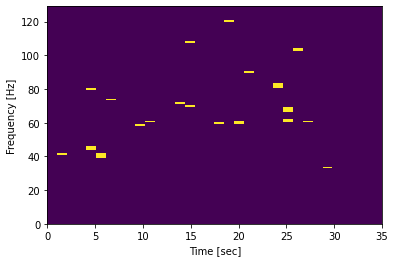

finished creating a fingerprint


[[ 5.  5. 39. 40.]
 [ 5.  5. 39. 41.]
 [ 5.  5. 40. 41.]
 [ 1.  4. 41. 44.]
 [ 1.  4. 41. 45.]
 [ 1.  5. 41. 39.]
 [ 4.  4. 44. 45.]
 [ 4.  5. 44. 39.]
 [ 4.  5. 44. 40.]
 [ 4.  5. 45. 39.]
 [ 4.  5. 45. 40.]
 [ 4.  5. 45. 41.]
 [ 9. 10. 58. 60.]
 [ 9. 17. 58. 59.]
 [17. 19. 59. 59.]
 [17. 19. 59. 60.]
 [17. 24. 59. 60.]
 [19. 19. 59. 60.]
 [19. 24. 59. 60.]
 [19. 24. 59. 61.]
 [10. 14. 60. 69.]
 [10. 17. 60. 59.]
 [10. 19. 60. 59.]
 [19. 24. 60. 60.]
 [19. 24. 60. 61.]
 [19. 24. 60. 66.]
 [24. 24. 60. 61.]
 [24. 24. 60. 66.]
 [24. 24. 60. 67.]
 [24. 24. 61. 66.]
 [24. 24. 61. 67.]
 [24. 24. 61. 68.]
 [24. 24. 66. 67.]
 [24. 24. 66. 68.]
 [24. 26. 66. 60.]
 [24. 24. 67. 68.]
 [24. 26. 67. 60.]
 [24. 26. 68. 60.]
 [14. 17. 69. 59.]
 [14. 19. 69. 59.]
 [14. 19. 69. 60.]
 [13. 14. 71. 69.]
 [ 6. 13. 73. 71.]
 [ 6. 14. 73. 69.]
 [ 4.  6. 79. 73.]
 [ 4. 13. 79. 71.]
 [23. 23. 80. 81.]
 [23. 23. 80. 82.]
 [23. 23. 81. 82.]
 [20. 23. 89. 80.]
 [20. 23. 89. 81

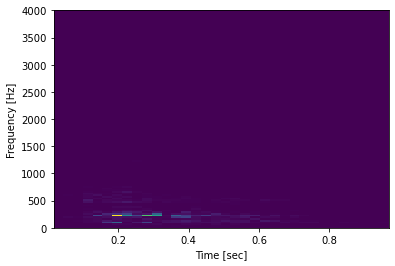

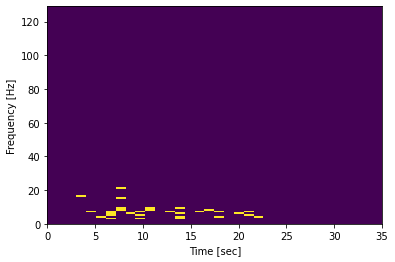

finished creating a fingerprint


[[ 9.  9.  3.  5.]
 [ 9.  9.  3.  7.]
 [ 9. 10.  3.  8.]
 [13. 13.  3.  4.]
 [13. 13.  3.  6.]
 [13. 13.  3.  9.]
 [ 5.  6.  4.  3.]
 [ 5.  6.  4.  5.]
 [ 5.  6.  4.  6.]
 [13. 13.  4.  6.]
 [13. 13.  4.  9.]
 [13. 15.  4.  7.]
 [17. 17.  4.  7.]
 [17. 19.  4.  6.]
 [17. 20.  4.  5.]
 [ 6.  6.  5.  6.]
 [ 6.  6.  5.  7.]
 [ 6.  7.  5.  8.]
 [ 9.  9.  5.  7.]
 [ 9. 10.  5.  8.]
 [ 9. 10.  5.  9.]
 [20. 20.  5.  7.]
 [20. 21.  5.  4.]
 [ 6.  6.  6.  7.]
 [ 6.  7.  6.  8.]
 [ 6.  7.  6.  9.]
 [ 8.  9.  6.  3.]
 [ 8.  9.  6.  5.]
 [ 8.  9.  6.  7.]
 [13. 13.  6.  9.]
 [13. 15.  6.  7.]
 [13. 16.  6.  8.]
 [19. 20.  6.  5.]
 [19. 20.  6.  7.]
 [19. 21.  6.  4.]
 [ 4.  5.  7.  4.]
 [ 4.  6.  7.  3.]
 [ 4.  6.  7.  5.]
 [ 6.  7.  7.  8.]
 [ 6.  7.  7.  9.]
 [ 6.  7.  7. 15.]
 [ 9. 10.  7.  8.]
 [ 9. 10.  7.  9.]
 [ 9. 12.  7.  7.]
 [12. 13.  7.  3.]
 [12. 13.  7.  4.]
 [12. 13.  7.  6.]
 [15. 16.  7.  8.]
 [15. 17.  7.  4.]
 [15. 17.  7.  7.]
 [17. 19.  7.  6

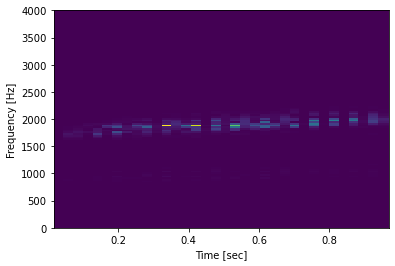

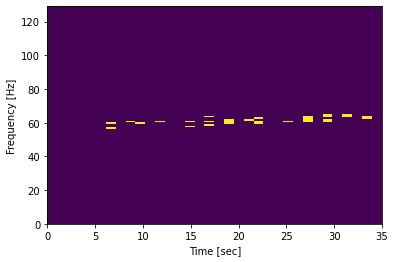

finished creating a fingerprint


[[14. 14. 57. 60.]
 [14. 16. 57. 58.]
 [14. 16. 57. 60.]
 [16. 16. 58. 60.]
 [16. 16. 58. 63.]
 [16. 18. 58. 59.]
 [ 6.  8. 59. 60.]
 [ 6.  9. 59. 59.]
 [ 6. 11. 59. 60.]
 [ 9. 11. 59. 60.]
 [ 9. 14. 59. 57.]
 [ 9. 14. 59. 60.]
 [18. 18. 59. 60.]
 [18. 18. 59. 61.]
 [18. 20. 59. 61.]
 [21. 21. 59. 60.]
 [21. 21. 59. 62.]
 [21. 24. 59. 60.]
 [ 8.  9. 60. 59.]
 [ 8. 11. 60. 60.]
 [ 8. 14. 60. 57.]
 [11. 14. 60. 57.]
 [11. 14. 60. 60.]
 [11. 16. 60. 58.]
 [14. 16. 60. 58.]
 [14. 16. 60. 60.]
 [14. 16. 60. 63.]
 [16. 16. 60. 63.]
 [16. 18. 60. 59.]
 [16. 18. 60. 60.]
 [18. 18. 60. 61.]
 [18. 20. 60. 61.]
 [18. 21. 60. 59.]
 [21. 21. 60. 62.]
 [21. 24. 60. 60.]
 [21. 26. 60. 60.]
 [24. 26. 60. 60.]
 [24. 26. 60. 61.]
 [24. 26. 60. 62.]
 [26. 26. 60. 61.]
 [26. 26. 60. 62.]
 [26. 26. 60. 63.]
 [28. 28. 60. 61.]
 [28. 28. 60. 63.]
 [28. 28. 60. 64.]
 [18. 20. 61. 61.]
 [18. 21. 61. 59.]
 [18. 21. 61. 60.]
 [20. 21. 61. 59.]
 [20. 21. 61. 60.]
 [20. 21. 61. 62

In [10]:
# Add songs to songid and fingerprints to hashtable

global hashtable

songIndex = len(songid)  #This becomes the song ID number.

someNewSongs = 0 # True if detects a new song in ith for-loop
for i in range(0,len(songs)):
    print(songs)
    # Check if the song is already in the database (hashtable)
    songFound = 0 # True if finds a song in the database (hashtable)
    for m in range(1,len(songid)):
        if (songs[i] == songid[m]):
            songFound = 1
            print("found")
            break
    
    # Create song fingerprint and store to table if not found
    if not songFound:
        someNewSongs = 1
        songIndex = songIndex + 1
        #decode the song
        newSong = songs[i]
        this_rate, this_data = wavfile.read(newSong)
        #add the song to the songid
        songid.append(songs[i])
        #find fingerprint (function: getFingerprint)
        this_fingerprint = getFingerprint(newSong, this_rate, this_data)
        #convert to pairs in table (function: convert_to_pairs)
        this_table = convert_to_pairs(this_fingerprint)
        #add data to hash table (function: add_to_table)
        add_to_table(this_table, songIndex)


In [11]:
#write current data to files

global numSongs
numSongs = songIndex
if someNewSongs:
    #write songid to file
    song_id_file = open("SONGID.txt","w") 
    for i in range(0, len(songid)):
        song_id_file.writelines(songid[i])
        song_id_file.write("\n")
    song_id_file.close()

    ##write hashtable to file
    with open('HASHTABLE.txt', 'w') as hashtable_file:
        for i in range (0, len(hashtable)):
            list1 = hashtable[i][0]
            list2 = hashtable[i][1]
            if not list1:
                #print("list 1 at %i is empty" % i)
                hashtable_file.write(" ")
            else:
                for j in list1:
                    hashtable_file.write("%f " % j)
            hashtable_file.write(" / ")
            if not list2:
                #print("list 2 at %i is empty" % i)
                hashtable_file.write(" ")
            else:
                for j in list2:
                    hashtable_file.write("%f " % j)
            hashtable_file.write("\n")
    hashtable_file.close()

    

## Part 2

Part 2 of the project will be buiding the part of Shazam that identifies the segment of music.
The main steps of the algorithm are the following:
- Load HASHTABLE and SONGID that were createdin part 1. 
- Prepare a clip of music for identification.
- Extract the list of frequency pairs from the clip.
- Look up matches in the hash table, calculate time offsets, and sort them by song. 
- Identify the song with the most matches for a single consistent timing offset.

From 2.1 to 2.3, you will rewrite and `match_segment.m` into Python and complete the function.

### 2.1 Extracting Features from the Input Clip

Extract the features from the sound clip with the procedure 1.1 - 1.6


Create a new fingerprint of the song:
toad_fixed.wav :
show spectrogram of the song: 


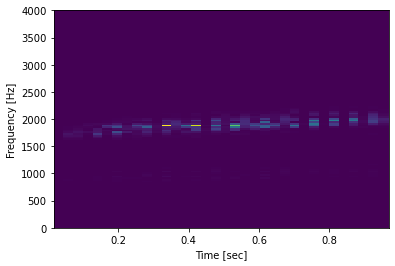

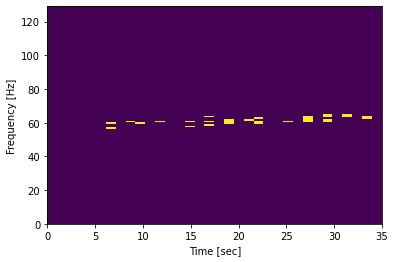

finished creating a fingerprint


[[14. 14. 57. 60.]
 [14. 16. 57. 58.]
 [14. 16. 57. 60.]
 [16. 16. 58. 60.]
 [16. 16. 58. 63.]
 [16. 18. 58. 59.]
 [ 6.  8. 59. 60.]
 [ 6.  9. 59. 59.]
 [ 6. 11. 59. 60.]
 [ 9. 11. 59. 60.]
 [ 9. 14. 59. 57.]
 [ 9. 14. 59. 60.]
 [18. 18. 59. 60.]
 [18. 18. 59. 61.]
 [18. 20. 59. 61.]
 [21. 21. 59. 60.]
 [21. 21. 59. 62.]
 [21. 24. 59. 60.]
 [ 8.  9. 60. 59.]
 [ 8. 11. 60. 60.]
 [ 8. 14. 60. 57.]
 [11. 14. 60. 57.]
 [11. 14. 60. 60.]
 [11. 16. 60. 58.]
 [14. 16. 60. 58.]
 [14. 16. 60. 60.]
 [14. 16. 60. 63.]
 [16. 16. 60. 63.]
 [16. 18. 60. 59.]
 [16. 18. 60. 60.]
 [18. 18. 60. 61.]
 [18. 20. 60. 61.]
 [18. 21. 60. 59.]
 [21. 21. 60. 62.]
 [21. 24. 60. 60.]
 [21. 26. 60. 60.]
 [24. 26. 60. 60.]
 [24. 26. 60. 61.]
 [24. 26. 60. 62.]
 [26. 26. 60. 61.]
 [26. 26. 60. 62.]
 [26. 26. 60. 63.]
 [28. 28. 60. 61.]
 [28. 28. 60. 63.]
 [28. 28. 60. 64.]
 [18. 20. 61. 61.]
 [18. 21. 61. 59.]
 [18. 21. 61. 60.]
 [20. 21. 61. 59.]
 [20. 21. 61. 60.]
 [20. 21. 61. 62

In [19]:
#load the clip and find its fingerprint
clip_rate, clip_data = wavfile.read('toad_fixed.wav')
clip_fingerprint = getFingerprint('toad_fixed.wav', clip_rate, clip_data)
clipTuples = convert_to_pairs(clip_fingerprint)
print(clipTuples)

### 2.2 Recovering matches from hash table

Use the frequencies and the time difference of the peak pair (f1, f2, t2 − t1) as inputs to the hash function, exactly as was done in add to table.m. Then extract the two lists from the hash table saved at the location provided by the hash function. Then, convert the timing list to a list of timing offsets by subtracting the time t1 that the peak pair occurred in the clip. This list of offsets is what we will save.

#We could then store the timing  𝑡1  and  𝑠𝑜𝑛𝑔𝑖𝑑  in the hash table. (matchID, matchTime)
#When a clip of song is to be identified, the list of pairs of peaks is produced (clipTuples)
#Then the hash table is searched for each pair in the clip. (for k in range 0, len(clipTuples))
#This will produce a list of matches, each with different stored values of  𝑡1  and songid. ie. a match has a songid and a t1
#Some of these matches will be accidental, either because the same peak pair occurred at another time or in another song, or because the hash table had a collision. However, we expect the correct song match to have a consistent timing offset from the clip. 
#That is, the difference between  𝑡1  for the song and  𝑡1  for the clip should be the same for all correct matches. The song with the most matches for a single timing offset is declared the winner.

In [25]:
# clipTuples = freq pair of clip


global hashtable
global numSongs

# Construct the cell of matches
matches = [[] for i in range (0, numSongs)]
for k in range(0,len(clipTuples)):
    #find the index of the song
    t1 = clipTuples[k][0] #t1
    t2 = clipTuples[k][1] #t2
    f1 = clipTuples[k][2] #f1
    f2 = clipTuples[k][3] #f2
    deltaT = t2 - t1
    size = len(hashtable)
    clipHash = simple_hash(f1, f2, deltaT, size)
    #print(clipHash)
    
    # If an entry exists with this hash, find the song(s) with matching peak pairs
    if hashtable[clipHash][0]:
        matchID = hashtable[clipHash][0] 
        print("matchID = ", matchID) #songidnum, a list
        for i in range(0, len(matchID)):
            print("matchID ", i, ": ", songid[matchID[i]-1])
        matchTime = hashtable[clipHash][1] #t1, a list
        print("matchTime = ", matchTime)
        
        # Calculate the time difference between clip pair and song pair
        timeOffset = t1 - matchTime # a list
        print("t1 = ", t1)
        print("timeOffset = ", timeOffset)
        
        # Add matches to the lists for each individual song
        count=0
        for n in matchID:
            matches[n-1].append(timeOffset[count])
            count = count +1
    else:
        print("no matching")
    print()
print(matches)


no matching

matchID =  [7]
matchID  0 :  toad_fixed.wav
matchTime =  [14.0]
t1 =  14.0
timeOffset =  [0.]

matchID =  [7]
matchID  0 :  toad_fixed.wav
matchTime =  [14.0]
t1 =  14.0
timeOffset =  [0.]

matchID =  [7]
matchID  0 :  toad_fixed.wav
matchTime =  [16.0]
t1 =  16.0
timeOffset =  [0.]

matchID =  [7]
matchID  0 :  toad_fixed.wav
matchTime =  [16.0]
t1 =  16.0
timeOffset =  [0.]

matchID =  [7]
matchID  0 :  toad_fixed.wav
matchTime =  [16.0]
t1 =  16.0
timeOffset =  [0.]

matchID =  [5, 7, 7]
matchID  0 :  music.wav
matchID  1 :  toad_fixed.wav
matchID  2 :  toad_fixed.wav
matchTime =  [17.0, 6.0, 9.0]
t1 =  6.0
timeOffset =  [-11.   0.  -3.]

matchID =  [7]
matchID  0 :  toad_fixed.wav
matchTime =  [6.0]
t1 =  6.0
timeOffset =  [0.]

matchID =  [5, 7, 7]
matchID  0 :  music.wav
matchID  1 :  toad_fixed.wav
matchID  2 :  toad_fixed.wav
matchTime =  [19.0, 6.0, 9.0]
t1 =  6.0
timeOffset =  [-13.   0.  -3.]

matchID =  [5, 7, 7]
matchID  0 :  music.wav
matchID  1 :  toad_fixed

### 2.3 Identifying the song

Find the song that has the most occurrences of any single timing offset. This is most easily done by looping through each song and using the mode command. 

In [26]:
import statistics
# # Find the counts of the mode of the time offset array for each song
# mode = most frequenct numbers in the array
ID = 0
Max_counts = 0
for k in range (0,len(matches)):
    counts = 0
    a = matches[k]
    if a:
        mode = statistics.mode(a)
        for i in a:
            if i == mode:
                counts = counts +1
        if counts > Max_counts:
            Max_counts = counts
            ID = k+1
print(Max_counts)
print("song id: ", ID)            
print("the song is: ", songid[ID-1])

79
song id:  7
the song is:  toad_fixed.wav
